# Self KL-divergence for detecting out of distribution data and unsupervised text classification
> Running two models alongside each other for trivial out of distribution detection in production models and side bonus is getting unsupervised text classification

- toc: true 
- badges: true
- comments: true
- categories: [ml, nlp, kldivergence]
- image: images/chart-preview.png

> TL;DR. By training two models at the same time (same architecture, same loss, but different initialization)
> I was able to obtain a consistent out-of-distribution detector by measuring the kl-divergence between model outputs.
> This out-of-distribution measure used on text could lead to unsupervised text classification.


## What's the problem ?

ML models usually are not really capable of predicting how well the data you     
feed them is close to what was in the dataset. It really matters in production 
models as they might make really stupid mistakes just because they are off       
the training set.                             


                     

Let's train a simple mnist model (straight out from pytorch tutorial https://github.com/pytorch/examples/tree/master/mnist)

In [1]:
#hide
!pip install torch torchvision

In [1]:
#collapse
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import os


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def mnist():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.expanduser('../data'), train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        
# mnist()



In [2]:
#hide
# Notebook specific hack
import sys; sys.argv=['']; del sys
mnist()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296684
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.748730
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.663051
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.494142
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.438472
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.384286
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.385418
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.250876
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.703926
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.355346
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.278224
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.331458
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.298988
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.209039
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.170960
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.115530
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.111752
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.204197
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.189492
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.153070
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.013835
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.066317
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.073026
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.013401
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.019004
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.121260
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.006645
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.091914
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.073917
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.023371
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.115739
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.219041
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.017631
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.094882
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.110504
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.048632
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.091261
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.007711
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.191920
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.039812


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.018943
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.000792
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.145806
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.103537
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.015214
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.021014
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.014712
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.025855
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.005132
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.007938
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.008412
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.006710
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.210589
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.036074
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.037000
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.033628
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.017531
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.004076
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.129550
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.020155


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.002318
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.040155
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.013842
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.002330
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.024685
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.003700
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.021113
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.057999
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.011047
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.067166
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.001192
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.000563
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.010040
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.007561
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.032846
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.013236
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.005575
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.000248
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.013824
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.002829


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.023662
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.002546
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.003831
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.100814

Test set: Average loss: 0.0306, Accuracy: 9912/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.058938
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.073502
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.011661
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.088264
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.001176
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.003380
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.000436
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.007919
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.096891
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.130878
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.039486
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.006028
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.007877
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.055661
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.003264
Train Epoch: 8 [9

Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.008067
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.000237
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.085330
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.006433
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.008115
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.053890
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.029573
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.032294
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.002944
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.044455
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.002994
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.002355
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.005650
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.002886
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.024059
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.011037
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.031738
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.007290
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.001360
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.027384


Train Epoch: 11 [23680/60000 (39%)]	Loss: 0.005141
Train Epoch: 11 [24320/60000 (41%)]	Loss: 0.003779
Train Epoch: 11 [24960/60000 (42%)]	Loss: 0.002934
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.006800
Train Epoch: 11 [26240/60000 (44%)]	Loss: 0.047343
Train Epoch: 11 [26880/60000 (45%)]	Loss: 0.001191
Train Epoch: 11 [27520/60000 (46%)]	Loss: 0.019012
Train Epoch: 11 [28160/60000 (47%)]	Loss: 0.006645
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.000137
Train Epoch: 11 [29440/60000 (49%)]	Loss: 0.006967
Train Epoch: 11 [30080/60000 (50%)]	Loss: 0.003553
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.021704
Train Epoch: 11 [31360/60000 (52%)]	Loss: 0.022560
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.030018
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.001215
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.031195
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.001450
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.008480
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.016842
Train Epoch: 11 [35840/60000 (6

Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.001477
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.074944
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.039781
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.002461
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.013462
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.004000
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.016036
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.005625
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.007050
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.007685
Train Epoch: 13 [12160/60000 (20%)]	Loss: 0.003282
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.006237
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.032054
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.015381
Train Epoch: 13 [14720/60000 (25%)]	Loss: 0.030208
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.011388
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.006131
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.001500
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.008928
Train Epoch: 13 [17920/60000 (30%)]	Lo

Train Epoch: 14 [48640/60000 (81%)]	Loss: 0.004727
Train Epoch: 14 [49280/60000 (82%)]	Loss: 0.006843
Train Epoch: 14 [49920/60000 (83%)]	Loss: 0.064283
Train Epoch: 14 [50560/60000 (84%)]	Loss: 0.016494
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.003054
Train Epoch: 14 [51840/60000 (86%)]	Loss: 0.006907
Train Epoch: 14 [52480/60000 (87%)]	Loss: 0.002740
Train Epoch: 14 [53120/60000 (88%)]	Loss: 0.022670
Train Epoch: 14 [53760/60000 (90%)]	Loss: 0.014527
Train Epoch: 14 [54400/60000 (91%)]	Loss: 0.006328
Train Epoch: 14 [55040/60000 (92%)]	Loss: 0.003450
Train Epoch: 14 [55680/60000 (93%)]	Loss: 0.010034
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.012088
Train Epoch: 14 [56960/60000 (95%)]	Loss: 0.004099
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.005905
Train Epoch: 14 [58240/60000 (97%)]	Loss: 0.001811
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.008665
Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.031875

Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99%)



Then generate an random image for which the model is highly confident yet it's completely absurd. This new image is out of distribution yet the model does not know it. We want to avoid doing such mistakes in production.

MNIST Model says : This is a 3 with probability 99.99%


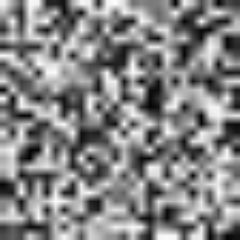

In [3]:
#collapse
from torch.distributions import Categorical
from torch.nn.parameter import Parameter
from torchvision import transforms

mnist_model = Net()
mnist_model.load_state_dict(torch.load('mnist_cnn.pt'))

dummy_input = Parameter(torch.rand(1, 1, 28, 28, requires_grad=True))

lr = 1
optimizer = optim.Adadelta([dummy_input], lr=lr)
for i in range(100):
    output = mnist_model(dummy_input)
    entropy = Categorical(logits = output).entropy()
    # print(f'Entropy {entropy.item():.2f}')
    optimizer.zero_grad()
    entropy.backward()
    optimizer.step()

MAX = output[0].exp().max(dim=-1)
print(f"MNIST Model says : This is a {MAX.indices.item()} with probability {MAX.values.item() * 100:.2f}%")
pil_img = transforms.Resize((240, 240))(transforms.ToPILImage()(dummy_input[0]))
display(pil_img)


## Other approaches


Other out of distribution detector have been proposed. Here is a sample of methods:

- [Likelihood Ratios for Out-of-Distribution Detection](https://arxiv.org/pdf/1906.02845.pdf): Propose to learn 2 distinct models, one "raw", one with perturbation instilled into the dataset, and look at the log likelihood ratio of the two models, claim is that the difference between the two will reflect how "far" input is from the semantic part of the manifold of X. $p(x) = p(x_background)p(x_semantic)$, the perturbation needs to lie only on $x_semantic$.
- [Out-of-distribution Detection in Classifiers via Generation](https://arxiv.org/pdf/1910.04241.pdf): Propose to use autoencoder (or GANs) to generate a low dimensional representation of the manifold of the dataset X, then perturb X on that representation. Those perturbated examples are trained to become a new "class" of the output of the classifier. 
- [Enhancing the reliability of Out-of-Distribution Image Detection in Neural Networks (Odin)](https://arxiv.org/pdf/1706.02690.pdf): This one uses temperature scaling regarding softmax to generate perturbated input, then look at the probability of the softmax if it passes a threshold. IMO, this paper is interesting as it supposes smoothness properties on In distribution data, and less smooth for out-of-distribution. It does require some examples of out-of-distribution for fitting 3 hyperparameters (temperature, threshold and magnitude of perturbation)
- [Your classifier is secretly an energy based model and you should treat it like one](https://openreview.net/pdf?id=Hkxzx0NtDB): This one adds a new term in the loss to estimate p(x) basically. Multiple ood detectors are proposed, the most efficient being the second derivative of p(x), claiming again that density of p(x) will change more widly in ood space, leading to a good ood detector.

- [WAIC, but Why? Generative Ensembles for Robust Anomaly Detection](https://arxiv.org/pdf/1810.01392.pdf): This paper proposes to use an ensemble of models and look at WAIC criterion to detect OOD. It makes many comparison to VAE and GANs

- [Learning Confidence for Out-of-Distribution Detection in Neural Networks](https://arxiv.org/pdf/1802.04865v1.pdf) : The core idea in this paper is to change the learning loss, to learn confidence as prior task to classification task, a model is allowed to see real label only when it claims it can solve the problem, outputting via another head directly a confidence score. Caveat is that the model might choose to give up and always claim confidence, and another trick is proposed to emphasize the in-distribution vs out-of-distribution by preprocessing inputs to move them towards region of higher confidence. In-distribution tends to move closer to 1 than out-of-distribution. So the direct confidence estimator seems to be *smoother* out-of-distribution than in-distribution, where peaks are more likely to be found.

- [Papers with code](https://paperswithcode.com/task/out-of-distribution-detection): More links on that hopefully

## Our approach

> **Tl;dr : Make two similar models, with two different random initialization, then train them at the same time.
> The ood detector will simply be the a threshold classifier on the KL-divergence between the two outputs.**

The core argument for this approach is that the neural network captures the dataset manifold (which means it will produce "regular" outputs for in dataset items). For the range of possible values it has random values for a random initialization. If that is true, then we train the model, we shift it's output only on the dataset manifold, and not anywhere else. If that assumption is correct, then the 2 models have very low probability of concurring in their output outside of the manifold if they have been initialized differently.

It's quite close to WAIC, *but* the two models need to be trained at the same time. The argument is that is should align gradients during the training phase, leading to more correlation for in-dataset prediction for the models. The argument for this supposes that the lottery ticket hypothesis is true, and adds that lottery ticket is unique (or at least that the class of lottery tickets is very thin, and they all highly correlate to each other). If this is true, then the gradients within the network that correspond to this lottery ticket winner in *both* networks should be the same (or highly correlated).

In order to fix the threshold, we found that simply setting it to be 10x the average kl-divergence obtained on the train dataset worked pretty well. As kl divergence is measured in bits, 10x is a quite large margin. More work could be done to study more closely the behaviour of this self kl-divergence.

## Experiments

### Experiment 1

MNIST attack like failure presented before.




In [69]:
class MultiNet(nn.Module):
    def __init__(self, *models):
        super().__init__()
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        return [model(x) for model in self.models]

    
def train_multi(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = sum(F.nll_loss(output, target) for output in outputs)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_multi(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += sum(F.nll_loss(output, target, reduction='sum').item() for output in outputs)
            pred = outputs[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def mnist_multi():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.expanduser('../data'), train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model1 = Net()
    model2 = Net()
    model = MultiNet(model1, model2).to(device)

    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_multi(args, model, device, train_loader, optimizer, epoch)
        test_multi(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_multi_cnn.pt")
        

# mnist_multi()

In [ ]:
#hide
# Notebook specific hack
import sys; sys.argv=['']; del sys
mnist_multi()

In [24]:
from torchvision import datasets
def kl(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            
            test_loss += 1/2 * (F.kl_div(outputs[0], outputs[1].exp(), reduction='sum').item() + F.kl_div(outputs[1], outputs[0].exp(), reduction='sum').item())


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, len {} \n'.format(
        test_loss, len(test_loader.dataset)))
    return test_loss
    
multi_model = MultiNet(Net(), Net())
multi_model.load_state_dict(torch.load('mnist_multi_cnn.pt'))


test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.expanduser('../data'), train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True)
ref_kl_loss = kl(multi_model, device='cpu', test_loader=test_loader)



Test set: Average loss: 0.0069, len 10000 



Now we have 2 models capable of detecting digits, we have instantly 3 checks for checking if the output of our model is valid. The 2 models need to be concording (they need to outputs the same digit as an output), they need to have similar kl-divergence, we actually have a reference for the test set, so we know what kind of divergence we should look for, anything 10x more is definitely ood (we could look at the test set distribution for more fine grain estimation). Because kl divergence is asymetric we have 2 values (it's harder for spiked distribution to have another distribution be close in the kl sense, so taking the max of kl-divergence should be used for out-of-distribution.


In [27]:
#collapse
from torch.distributions import Categorical
from torch.nn.parameter import Parameter
from torchvision import transforms

def attack(loss_fn, verbose=True, n=100, lr=1):
    multi_model = MultiNet(Net(), Net())
    multi_model.load_state_dict(torch.load('mnist_multi_cnn.pt'))

    dummy_input = Parameter(torch.rand(1, 1, 28, 28, requires_grad=True))

    optimizer = optim.Adadelta([dummy_input], lr=lr)
    for i in range(n):
        outputs = multi_model(dummy_input)
        
        loss = loss_fn(outputs)
        # print(f'Entropy {entropy.item():.2f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    MAX1 = outputs[0][0].exp().max(dim=-1)
    MAX2 = outputs[1][0].exp().max(dim=-1)

    kl_loss = F.kl_div(outputs[0], outputs[1].exp(), reduction='batchmean')
    kl_loss2 = F.kl_div(outputs[1], outputs[0].exp(), reduction='batchmean')

    if (kl_loss / ref_kl_loss) > 10 or kl_loss2 / ref_kl_loss > 10 or MAX1.indices.item() != MAX2.indices.item():
        success = False
    else:
        success = True
    if verbose:
        print(f"MNIST Model says : This is a {MAX1.indices.item()} with probability {MAX1.values.item() * 100:.2f}%")
        print(f"MNIST Model 2 says : This is a {MAX2.indices.item()} with probability {MAX2.values.item() * 100:.2f}%")

        print(f"KL-divergence is {kl_loss / ref_kl_loss} {kl_loss2 / ref_kl_loss}")

        if success:
            print("ATTACK SUCCEEDED")
        else:
            print("ATTACK FAILED")
        pil_img = transforms.Resize((240, 240))(transforms.ToPILImage()(dummy_input[0]))
        display(pil_img)
    return success
        
        
  


Now if we simply attack the first model like we did earlier, we can see that we can trick it as easily as before. *BUT* the second model, does not get attacked which is to be expected.

MNIST Model says : This is a 5 with probability 99.32%
MNIST Model 2 says : This is a 1 with probability 51.35%
KL-divergence is 879.1231689453125 221.9772186279297
ATTACK FAILED


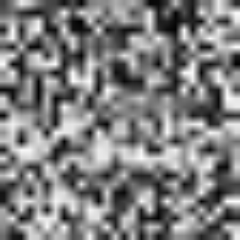

False

In [14]:
def loss(outputs):
    entropy = Categorical(logits = outputs[0]).entropy()
    
    loss = entropy
    return loss

attack(loss)


Even if we try a smarter and attack __both__ models at the same time, we can't succeed at a consistent rate. Be warned, it will succeed sometimes, just not consistently.

MNIST Model says : This is a 7 with probability 11.34%
MNIST Model 2 says : This is a 1 with probability 11.91%
KL-divergence is 0.8557947278022766 0.8770337104797363
ATTACK FAILED


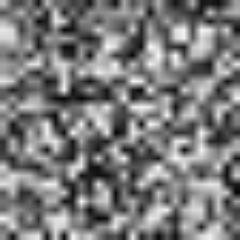

False

In [20]:
def loss(outputs):
    entropy1 = Categorical(logits = outputs[0]).entropy()
    entropy2 = Categorical(logits = outputs[1]).entropy()

    kl_loss1 = F.kl_div(outputs[0], outputs[1].exp(), reduction='batchmean')
    kl_loss2 = F.kl_div(outputs[1], outputs[0].exp(), reduction='batchmean')

    distance = F.mse_loss(outputs[0], outputs[1])

    loss = entropy1 + entropy2  + kl_loss1 + kl_loss2 + distance
    return loss
    
_ = attack(loss)
    

Be warned, it will succeed sometimes, just not consistently. For comparison, the first attack succeeds with close to 100% (we couldn't make it fail). Actually because we have 10 classes, and if we supposed out-of-distribution probability distribution is uniformly random, it should be something close to 10%, when our initial random image finds a place where the 2 models intersect on the same digit. 

In [28]:
def loss(outputs):
    entropy1 = Categorical(logits = outputs[0]).entropy()
    entropy2 = Categorical(logits = outputs[1]).entropy()

    kl_loss1 = F.kl_div(outputs[0], outputs[1].exp(), reduction='batchmean')
    kl_loss2 = F.kl_div(outputs[1], outputs[0].exp(), reduction='batchmean')

    distance = F.mse_loss(outputs[0], outputs[1])

    loss = entropy1 + entropy2  + kl_loss1 + kl_loss2 + distance
    return loss
    
attacks = []
for i in range(100):
    success = attack(loss, verbose=False, n=200, lr=0.1)
    if success:
        print("F", end='')
    else:
        print(".", end='')
    attacks.append(success)

print('')
print(f"Attack success rate {sum(attacks)/len(attacks) * 100:.2f}%")
    

.........FF.F...F.FF.F..F....FF...F..FF..F.F.F.FF....F....F.......FF......FF.F.FFF.FF..F............Attack success rate 31.00%


The actual attack range seems to stagnate at around 30% (max observed 41%) with various learning rates and attack steps. There probably are better strategies to attack, this, but the main point is that it became __harder__. This is expected to be a property of the *output landscape*, as the number of classes increases, it should become harder still. Yet as the 30% is larger than the expected 10%, something else might be at play.

### Experiment 2

Now let's test this on common ood detection for classic datasets. We will add ood detection for the train dataset, just to check that we don't *exclude* too much of the original dataset. Datasets used will be MNIST, FashionMNIST

In [76]:
#collapse
from torchvision.datasets import MNIST, Omniglot, FashionMNIST
from torchvision import transforms
import os

datasets = [MNIST, FashionMNIST]

def dataset_multi(dataset_cls, filename):
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1e-2, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        dataset_cls('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
                dataset_cls('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                                    ])), batch_size = args.test_batch_size)

    model1 = Net()
    model2 = Net()
    model = MultiNet(model1, model2).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.CyclicLR(                             
          optimizer, base_lr=0, max_lr=args.lr, cycle_momentum=False, step_size_up=200                    )
    for epoch in range(1, args.epochs + 1):
        train_multi(args, model, device, train_loader, optimizer, epoch)
        test_multi(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), filename)


def run_datasets():
    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}.pt'

        if os.path.exists(filename):
            continue

        dataset_multi(dataset_cls, filename)

# run_datasets()


In [77]:
#hide
# Notebook specific hack
import sys; sys.argv=['']; del sys
run_datasets()

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.678443
Train Epoch: 1 [640/60000 (1%)]	Loss: 4.658801
Train Epoch: 1 [1280/60000 (2%)]	Loss: 4.649020
Train Epoch: 1 [1920/60000 (3%)]	Loss: 4.619276
Train Epoch: 1 [2560/60000 (4%)]	Loss: 4.667685
Train Epoch: 1 [3200/60000 (5%)]	Loss: 4.653006
Train Epoch: 1 [3840/60000 (6%)]	Loss: 4.629105
Train Epoch: 1 [4480/60000 (7%)]	Loss: 4.640399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 4.653443
Train Epoch: 1 [5760/60000 (10%)]	Loss: 4.598194
Train Epoch: 1 [6400/60000 (11%)]	Loss: 4.622351
Train Epoch: 1 [7040/60000 (12%)]	Loss: 4.648350
Train Epoch: 1 [7680/60000 (13%)]	Loss: 4.637665
Train Epoch: 1 [8320/60000 (14%)]	Loss: 4.657411
Train Epoch: 1 [8960/60000 (15%)]	Loss: 4.681814
Train Epoch: 1 [9600/60000 (16%)]	Loss: 4.612526
Train Epoch: 1 [10240/60000 (17%)]	Loss: 4.648591
Train Epoch: 1 [10880/60000 (18%)]	Loss: 4.620812
Train Epoch: 1 [11520/60000 (19%)]	Loss: 4.620546
Train Epoch: 1 [12160/60000 (20%)]	Loss: 4.646947
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.477223
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.331496
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.566394
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.843693
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.751386
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.616609
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.432645
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.572365
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.685344
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.593223
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.284163
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.675099
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.393342
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.268499
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.454146
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.378899
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.781233
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.507888
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.607300
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.607787


Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.502126
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.102437
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.131273
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.320770
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.209073
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.067102
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.172401
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.188451
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.152724
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.224100
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.125329
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.190523
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.184507
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.109688
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.164217
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.096106
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.103079
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.181615
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.102945
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.126091


Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.040661
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.183396
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.157757
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.124423
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.203818
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.256351
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.396387
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.236342
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.249214
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.064175
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.253521
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.057811
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.143910
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.109388
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.093677
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.217357
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.146043
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.195511
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.109836
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.137149


Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.040046
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.050925
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.088096

Test set: Average loss: 0.0751, Accuracy: 9866/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.101928
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.077202
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.081408
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.089856
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.021517
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.465495
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.042327
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.108641
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.105622
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.035720
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.130676
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.147733
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.139844
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.071648
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.023821
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.252280
Train Epoch: 8 [10

Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.350248
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.086167
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.249401
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.329739
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.324897
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.023771
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.047472
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.048374
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.335635
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.022069
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.216971
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.024891
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.073600
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.050023
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.085659
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.020467
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.042854
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.142207
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.419847
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.159620


Train Epoch: 11 [24320/60000 (41%)]	Loss: 0.076742
Train Epoch: 11 [24960/60000 (42%)]	Loss: 0.049145
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.082274
Train Epoch: 11 [26240/60000 (44%)]	Loss: 0.057610
Train Epoch: 11 [26880/60000 (45%)]	Loss: 0.400132
Train Epoch: 11 [27520/60000 (46%)]	Loss: 0.028930
Train Epoch: 11 [28160/60000 (47%)]	Loss: 0.028511
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.051149
Train Epoch: 11 [29440/60000 (49%)]	Loss: 0.008368
Train Epoch: 11 [30080/60000 (50%)]	Loss: 0.082019
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.014026
Train Epoch: 11 [31360/60000 (52%)]	Loss: 0.010097
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.059406
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.117745
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.054272
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.145846
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.052626
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.059534
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.104537
Train Epoch: 11 [36480/60000 (6

Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.006851
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.302071
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.086137
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.131942
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.034887
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.228863
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.106835
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.025735
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.040329
Train Epoch: 13 [12160/60000 (20%)]	Loss: 0.096298
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.068281
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.018559
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.064540
Train Epoch: 13 [14720/60000 (25%)]	Loss: 0.030934
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.004238
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.216706
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.141115
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.052886
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.094480
Train Epoch: 13 [18560/60000 (31%)]	L

Train Epoch: 14 [49280/60000 (82%)]	Loss: 0.502742
Train Epoch: 14 [49920/60000 (83%)]	Loss: 0.103783
Train Epoch: 14 [50560/60000 (84%)]	Loss: 0.329141
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.031755
Train Epoch: 14 [51840/60000 (86%)]	Loss: 0.038848
Train Epoch: 14 [52480/60000 (87%)]	Loss: 0.125051
Train Epoch: 14 [53120/60000 (88%)]	Loss: 0.089050
Train Epoch: 14 [53760/60000 (90%)]	Loss: 0.126881
Train Epoch: 14 [54400/60000 (91%)]	Loss: 0.030019
Train Epoch: 14 [55040/60000 (92%)]	Loss: 0.058595
Train Epoch: 14 [55680/60000 (93%)]	Loss: 0.069381
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.032277
Train Epoch: 14 [56960/60000 (95%)]	Loss: 0.033214
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.059181
Train Epoch: 14 [58240/60000 (97%)]	Loss: 0.227141
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.062593
Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.169951

Test set: Average loss: 0.0643, Accuracy: 9904/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.673808
Train Epoch: 1 [640/60000 (

Train Epoch: 2 [33280/60000 (55%)]	Loss: 1.058681
Train Epoch: 2 [33920/60000 (57%)]	Loss: 1.064857
Train Epoch: 2 [34560/60000 (58%)]	Loss: 0.878353
Train Epoch: 2 [35200/60000 (59%)]	Loss: 1.490009
Train Epoch: 2 [35840/60000 (60%)]	Loss: 1.572579
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.926961
Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.968857
Train Epoch: 2 [37760/60000 (63%)]	Loss: 1.077733
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.526482
Train Epoch: 2 [39040/60000 (65%)]	Loss: 1.607954
Train Epoch: 2 [39680/60000 (66%)]	Loss: 1.145802
Train Epoch: 2 [40320/60000 (67%)]	Loss: 1.163990
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.876294
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.866080
Train Epoch: 2 [42240/60000 (70%)]	Loss: 1.468978
Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.351028
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.072245
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.068767
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.146088
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.270903


Train Epoch: 4 [17280/60000 (29%)]	Loss: 0.728239
Train Epoch: 4 [17920/60000 (30%)]	Loss: 0.956684
Train Epoch: 4 [18560/60000 (31%)]	Loss: 0.959414
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.770230
Train Epoch: 4 [19840/60000 (33%)]	Loss: 0.625525
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.903163
Train Epoch: 4 [21120/60000 (35%)]	Loss: 0.817079
Train Epoch: 4 [21760/60000 (36%)]	Loss: 0.725252
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.825675
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.467297
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.584116
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.741253
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.841790
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.037671
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.960517
Train Epoch: 4 [26880/60000 (45%)]	Loss: 1.186827
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.765556
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.558553
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.549768
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.670393


Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.642837
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.601975
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.562313
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.558967
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.562836
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.226657
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.506545
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.464020
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.489343
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.848032
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.385828
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.364126
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.713487
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.778522
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.711092
Train Epoch: 6 [10880/60000 (18%)]	Loss: 1.024743
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.634985
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.628104
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.622564
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.662473
Train Epoch: 6 [14080

Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.719392
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.667354
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.464161
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.478197
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.271407
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.342742
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.736919
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.829605
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.019366
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.461153
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.694235
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.317106
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.499243
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.773002
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.723603
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.661827
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.309377
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.526974
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.596686
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.798740


Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.413157
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.203808
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.530979
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.363951
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.342181
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.642413
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.372060
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.369926
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.499412
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.243360
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.496434
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.769916
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.739880
Train Epoch: 9 [39040/60000 (65%)]	Loss: 0.339512
Train Epoch: 9 [39680/60000 (66%)]	Loss: 0.517998
Train Epoch: 9 [40320/60000 (67%)]	Loss: 0.672433
Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.253948
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.434998
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.162737
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.213270


Train Epoch: 11 [13440/60000 (22%)]	Loss: 0.406626
Train Epoch: 11 [14080/60000 (23%)]	Loss: 0.392589
Train Epoch: 11 [14720/60000 (25%)]	Loss: 0.277136
Train Epoch: 11 [15360/60000 (26%)]	Loss: 0.792968
Train Epoch: 11 [16000/60000 (27%)]	Loss: 0.471407
Train Epoch: 11 [16640/60000 (28%)]	Loss: 0.244332
Train Epoch: 11 [17280/60000 (29%)]	Loss: 0.473506
Train Epoch: 11 [17920/60000 (30%)]	Loss: 0.831768
Train Epoch: 11 [18560/60000 (31%)]	Loss: 0.310001
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.205651
Train Epoch: 11 [19840/60000 (33%)]	Loss: 0.447895
Train Epoch: 11 [20480/60000 (34%)]	Loss: 0.233634
Train Epoch: 11 [21120/60000 (35%)]	Loss: 0.562742
Train Epoch: 11 [21760/60000 (36%)]	Loss: 0.634941
Train Epoch: 11 [22400/60000 (37%)]	Loss: 0.256565
Train Epoch: 11 [23040/60000 (38%)]	Loss: 0.689846
Train Epoch: 11 [23680/60000 (39%)]	Loss: 0.559391
Train Epoch: 11 [24320/60000 (41%)]	Loss: 0.446611
Train Epoch: 11 [24960/60000 (42%)]	Loss: 0.491720
Train Epoch: 11 [25600/60000 (4

Train Epoch: 12 [56320/60000 (94%)]	Loss: 0.282071
Train Epoch: 12 [56960/60000 (95%)]	Loss: 0.435005
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.464853
Train Epoch: 12 [58240/60000 (97%)]	Loss: 0.245965
Train Epoch: 12 [58880/60000 (98%)]	Loss: 0.454898
Train Epoch: 12 [59520/60000 (99%)]	Loss: 0.982634

Test set: Average loss: 0.4770, Accuracy: 9118/10000 (91%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.306427
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.328410
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.272571
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.657770
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.429852
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.227559
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.438782
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.144411
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.531551
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.326070
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.664456
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.254271
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.489

Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.366971
Train Epoch: 14 [39040/60000 (65%)]	Loss: 0.429976
Train Epoch: 14 [39680/60000 (66%)]	Loss: 0.330161
Train Epoch: 14 [40320/60000 (67%)]	Loss: 0.424360
Train Epoch: 14 [40960/60000 (68%)]	Loss: 0.434064
Train Epoch: 14 [41600/60000 (69%)]	Loss: 0.498141
Train Epoch: 14 [42240/60000 (70%)]	Loss: 0.319677
Train Epoch: 14 [42880/60000 (71%)]	Loss: 0.534761
Train Epoch: 14 [43520/60000 (72%)]	Loss: 0.261612
Train Epoch: 14 [44160/60000 (74%)]	Loss: 0.517392
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.440436
Train Epoch: 14 [45440/60000 (76%)]	Loss: 0.254039
Train Epoch: 14 [46080/60000 (77%)]	Loss: 0.491410
Train Epoch: 14 [46720/60000 (78%)]	Loss: 0.369566
Train Epoch: 14 [47360/60000 (79%)]	Loss: 0.340459
Train Epoch: 14 [48000/60000 (80%)]	Loss: 0.284715
Train Epoch: 14 [48640/60000 (81%)]	Loss: 0.477594
Train Epoch: 14 [49280/60000 (82%)]	Loss: 0.507961
Train Epoch: 14 [49920/60000 (83%)]	Loss: 0.319872
Train Epoch: 14 [50560/60000 (8

In [80]:
from sklearn.metrics import roc_auc_score

In [81]:
def test_datasets():
    batch_size = 500
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}.pt'
        
        model = MultiNet(Net(), Net()).to(device)
        model.load_state_dict(torch.load(filename))
        test_loader = torch.utils.data.DataLoader(
                dataset_cls('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])), batch_size=batch_size)
        ref_kl_loss = kl(model, device, test_loader)
        print("Ref loss", ref_kl_loss)
        
        all_labels = []
        all_scores = []
        for dataset_cls2 in datasets:
            test_loader2 = torch.utils.data.DataLoader(
                dataset_cls2('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])),batch_size=batch_size, shuffle=True)
            
            
            OOD = 0
            for data, target in test_loader2:
                outputs = model(data.to(device))
                kl_loss = torch.max(F.kl_div(outputs[0], outputs[1].exp(), reduction='none'),  F.kl_div(outputs[1], outputs[0].exp(), reduction='none'))
                kl_loss = kl_loss.sum(dim=-1)
                
                similar = outputs[0].argmax(dim=-1) == outputs[1].argmax(dim=-1)
                
                normed = kl_loss / ref_kl_loss
                
                kl_anomaly = normed > 10
                non_concordant = similar == False
                
                out_of_distrib = sum(kl_anomaly | non_concordant)
                
                N = normed.shape[0]
                boolean = dataset_cls2 != dataset_cls
                all_labels.extend([boolean] * N)
                all_scores.extend(normed.tolist())
                
                
                OOD += out_of_distrib
            print(f"Trained on {dataset_cls.__name__} we detected on {dataset_cls2.__name__} {OOD}/{len(test_loader2.dataset)} ({float(OOD)/len(test_loader2.dataset) * 100:.2f}%) out of distribution")
                   
        auc = roc_auc_score(all_labels, all_scores)
        print(f"AUC for {dataset_cls.__name__} : {auc}")

test_datasets()


Test set: Average loss: 0.0204, len 10000 

Ref loss 0.0204180196672678
Trained on MNIST we detected on MNIST 350/10000 (3.50%) out of distribution
Trained on MNIST we detected on FashionMNIST 7334/10000 (73.34%) out of distribution
AUC for MNIST : 0.9692911949999999

Test set: Average loss: 0.0490, len 10000 

Ref loss 0.0490430459022522
Trained on FashionMNIST we detected on MNIST 6141/10000 (61.41%) out of distribution
Trained on FashionMNIST we detected on FashionMNIST 1040/10000 (10.40%) out of distribution
AUC for FashionMNIST : 0.8571711399999999


So we can see that we achieve, with no tuning whatsoever a decent out of distribution detector. We seem to achieve much better AUROC on MNIST, probably because the in-distribution learning seems to be much better (99% test accuracy vs 92% for fastionMNIST). So to False positives for fashionMNIST probably come from this hard to learn in-distribution. Some fine tuning needs to be done to get better results. We also have to keep in mind, that the models to learn this are quite small (2M parameters but only 2 convolution layers) so the lottery hypothesis validity for such a network might be questionned.

### Experiment 2 bis

Same experiment but with fine tuned, larger networks on the same datasets 

### Experiment 3

Check that two identical networks (same initalization) actually don't work. It's just a sanity check. We should obtain always kl_div = 0 no matter where we are in the input space.

### Experiment 4

Test on a larger output space, like CIFAR-100 and SVHN, to check that part of the limits are actually due to small number of output classes
for MNIST/FashionMNIST
Other idea is to test on Transformers. Early experiment seems to show that we can use that idea to detect different language within text with just the kl_div used as a distance.

Found French book within english books dataset, AND english paragraphs *within* this french book.
Needs some work to clean this experiment

### Experiment 5

Need to test with various training schemes, regularization schemes (dropout, batchnorm, l2 penalization) and so on. We should find that the smoother in-distribution our models behave the more this method should work. Hopefully test accuracy *should* be a good smoothness proxy.

### Experiment 6  (Unsupervised text classification) or fuse with experiment 4? 

- Show that small network trained on a single english book enables to detect different languages
  or different patterns of writing (old english, irish, french, or event dictionnaries)
- The detection is super fined grained capable of detecting english within a French book.

### Experiment 7

Run this method with 2, 3, 4, and so on models. We should get exponential improved accuracy, if the random behavious for out-of-distribution for models is correct.

## Limits

The pros for this method are that:
 - It's super simple to implement, and only costs a constant factor in training time.
 - You could also extend this to 3, 4 side models, and it *should* improve robustness exponentially if the random factors are correct. If we keep this number small, it will still be constant cost factor.
 - It does *not* require a perturbation model for input data, which in itself is subject to fine-tuning.


The cons is that:
- It does not work so well on low dimensional output spaces. 
- It seems other methods have better results than this one.
- It only works for models that output probability distributions (hard to extend to object detection, generation and other tasks)

 




## Future Work

There is a lot more experiments necessary to verify that the hypothesis in favor of that approach hold. Try to find ways to implement that in other tasks. How to improve out-of-distribution detection.